In [1]:
!pip install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade matplotlib==3.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 7.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import xgboost

from math import sqrt
from joblib import dump, load
from scipy.stats import weibull_min
from windrose import WindroseAxes
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K, callbacks, models, layers
from google.colab import drive

## Import Data

In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
electrical_data = pd.read_csv("/content/gdrive/MyDrive/ai-and-ds/thesis/ldt/LDT-10m-Tur-Ele_2017-2021.csv", parse_dates=["StartTime"])
meteorological_data = pd.read_csv("/content/gdrive/MyDrive/ai-and-ds/thesis/ldt/LDT-10m-Met_2017-2021.csv", parse_dates=["StartTime"])

##Exploratory Data Analysis

In [ ]:
# Select only the required features
electrical_data = electrical_data[["StartTime", "Power_kW_Mean"]].copy()
meteorological_data = meteorological_data[["StartTime", "Anemo_1_Mean", "Anemo_1_Stdev", "Anemo_4_Mean", "temp_T_Mean", "WindVane_T_Mean", "Barmoeter_1_Mean", "Barometer_2_Mean"]].copy()

In [ ]:
# Since there are two barometers the average of both is taken
meteorological_data["Barometer"] = meteorological_data[["Barmoeter_1_Mean", "Barometer_2_Mean"]].mean(axis=1)

In [ ]:
# Drop the other barometer reading since we have the mean
meteorological_data.drop(columns=["Barmoeter_1_Mean", "Barometer_2_Mean"], inplace=True)

In [ ]:
# Change column names to more meaningful names
electrical_data.columns = ["time", "power"]
meteorological_data.columns = ["time", "wind_speed_110m", "wind_speed_110m_std", "wind_speed_25m", "temperature", "wind_direction", "pressure"]

In [ ]:
# The electricial data starts earlier than the meteorological data so it is filtered for only times
# that are not ealier than the meteorological data
electrical_data = electrical_data[electrical_data.time >= meteorological_data.time.min()]

In [ ]:
# Merge the two datasets with an outer join using the time as the index.
df = pd.merge(electrical_data, meteorological_data, "outer", "time")

In [ ]:
# Sort the values based on time and reset indices
df.sort_values("time", inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259611 entries, 0 to 259610
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time                 259611 non-null  datetime64[ns]
 1   power                255872 non-null  float64       
 2   wind_speed_110m      244164 non-null  float64       
 3   wind_speed_110m_std  244147 non-null  float64       
 4   wind_speed_25m       244164 non-null  float64       
 5   temperature          245069 non-null  float64       
 6   wind_direction       245069 non-null  float64       
 7   pressure             244164 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 15.8 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
power,255872.0,1.224912e+03,2.014922e+03,-1.293231e+02,-0.746167,0.000000,1676.032442,7149.039182
wind_speed_110m,244164.0,7.070782e+00,3.920997e+00,0.000000e+00,4.005161,6.730861,9.572280,30.777336
wind_speed_110m_std,244147.0,6.846144e-01,4.827069e-01,0.000000e+00,0.321989,0.566376,0.941887,10.022062
wind_speed_25m,244164.0,5.609161e+00,3.206107e+00,0.000000e+00,3.252064,5.132828,7.374400,28.192528
temperature,245069.0,-6.400649e+10,3.168606e+13,-1.568601e+16,8.134293,11.620468,14.977240,26.586976
wind_direction,245069.0,1.894979e+02,9.041061e+01,0.000000e+00,101.878471,222.404832,252.559797,359.986961
pressure,244164.0,1.007118e+03,1.054774e+02,0.000000e+00,1011.090923,1019.329416,1025.534042,1048.059903


In [ ]:
sns.set_style("dark")
plt.rcParams['font.family'] = 'Serif'
plt.rcParams["font.size"] = 15

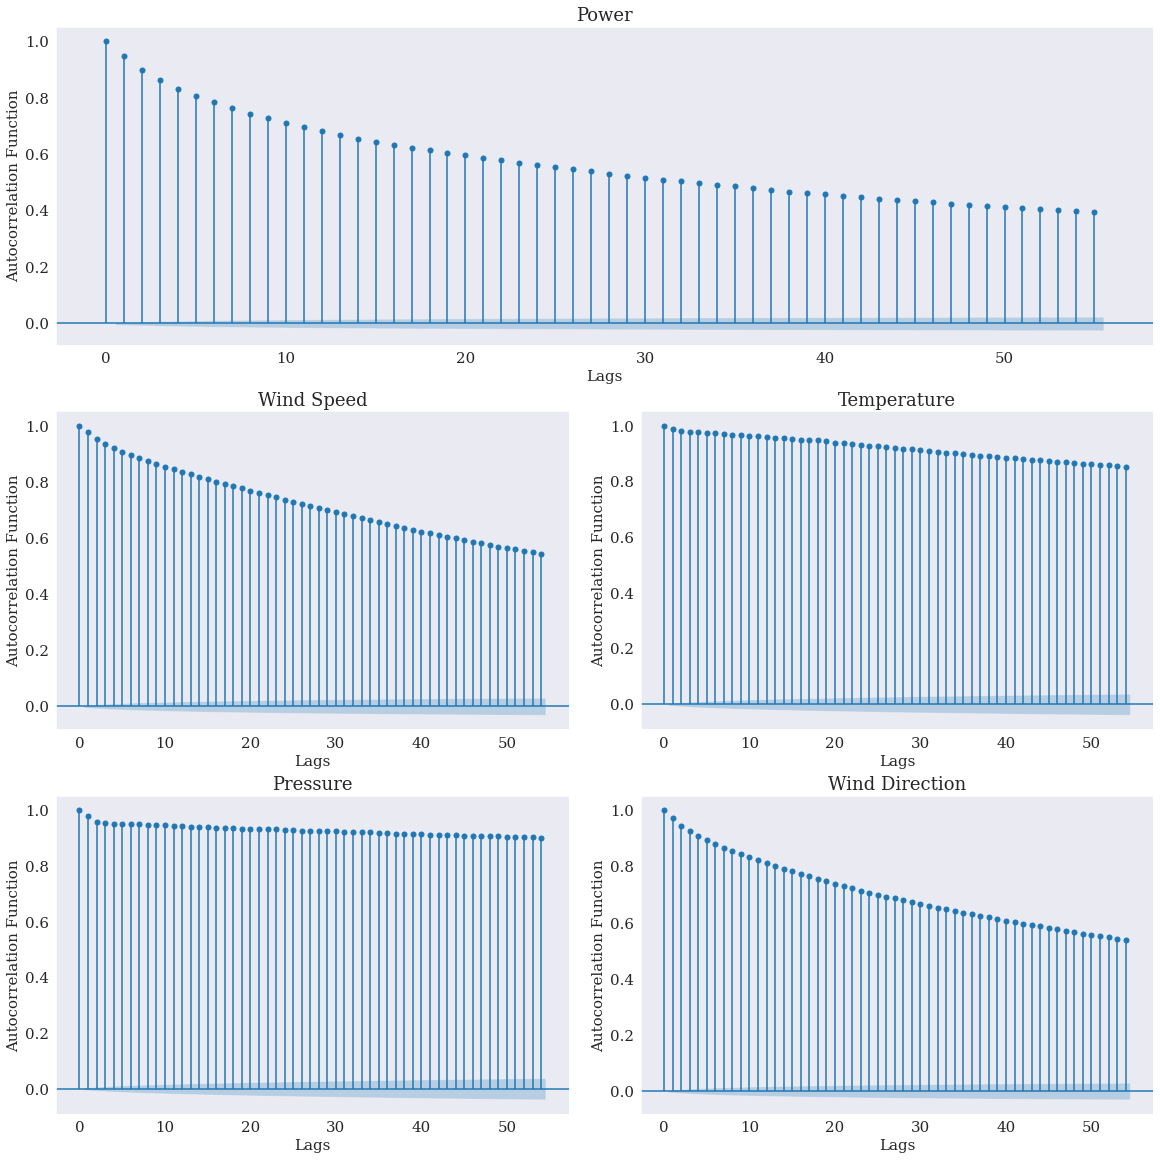

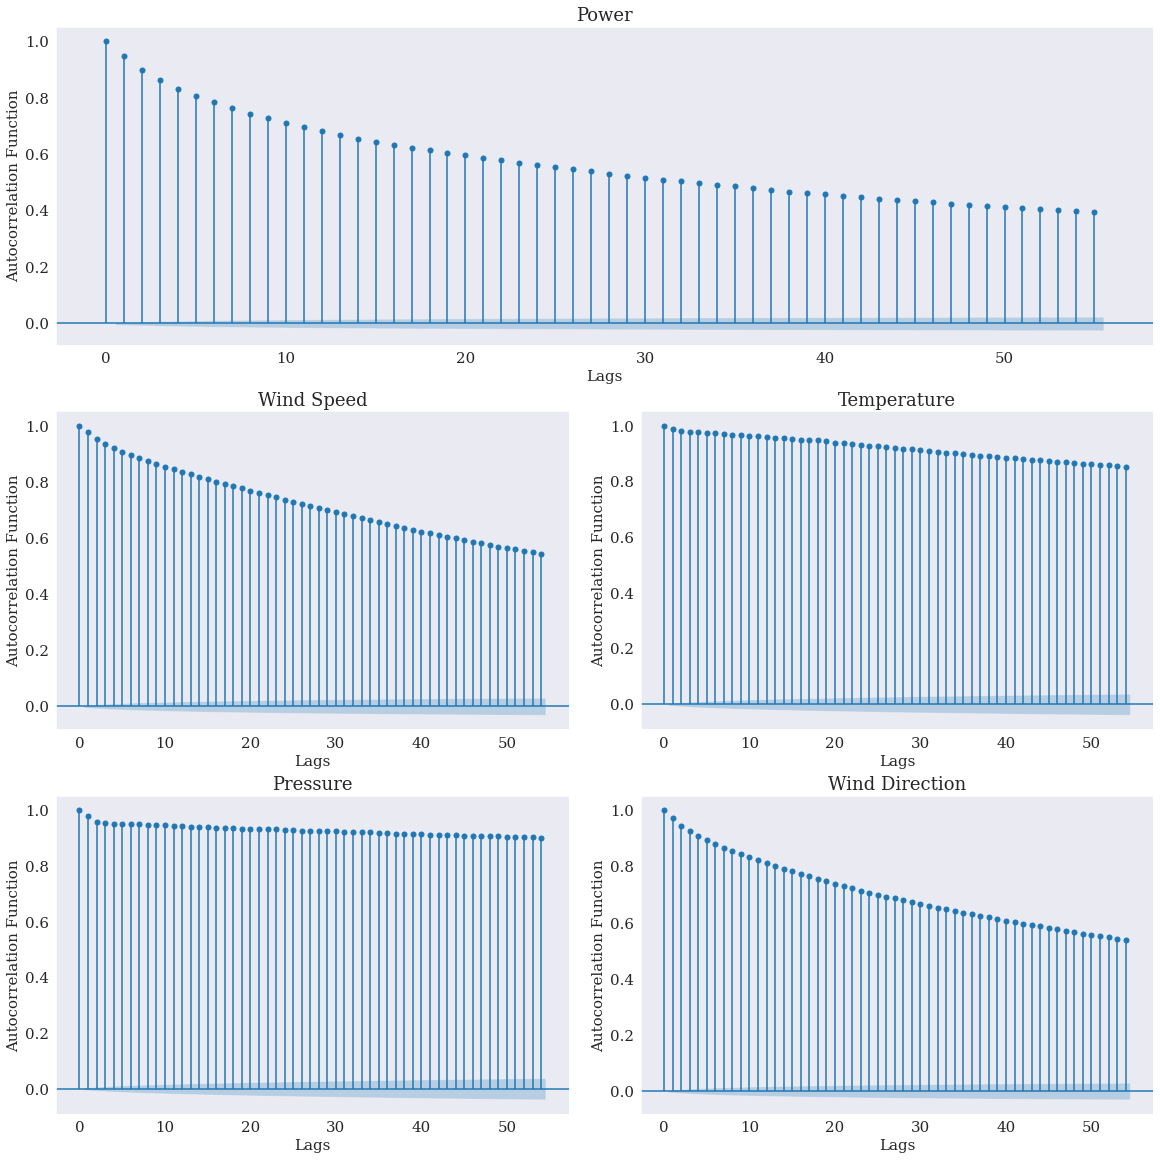

In [ ]:
fig, axes = plt.subplot_mosaic([["Power", 'Power'],
                               ['Wind Speed', 'Temperature'],
                               ["Pressure", "Wind Direction"]],
                              figsize=(16, 16),  constrained_layout=True)

for title, ax in axes.items():
    ax.set_title(title, fontsize=35)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation Function")

plot_acf(df.power.dropna(), ax=axes["Power"], title="Power")
plot_acf(df.wind_speed_110m.dropna(), ax=axes["Wind Speed"], title="Wind Speed")
plot_acf(df.temperature.dropna().drop(index=48045), ax=axes["Temperature"], title="Temperature")
plot_acf(df.pressure.dropna(), ax=axes["Pressure"], title="Pressure")
plot_acf(df.wind_direction.dropna(), ax=axes["Wind Direction"], title="Wind Direction")



#### Time Series

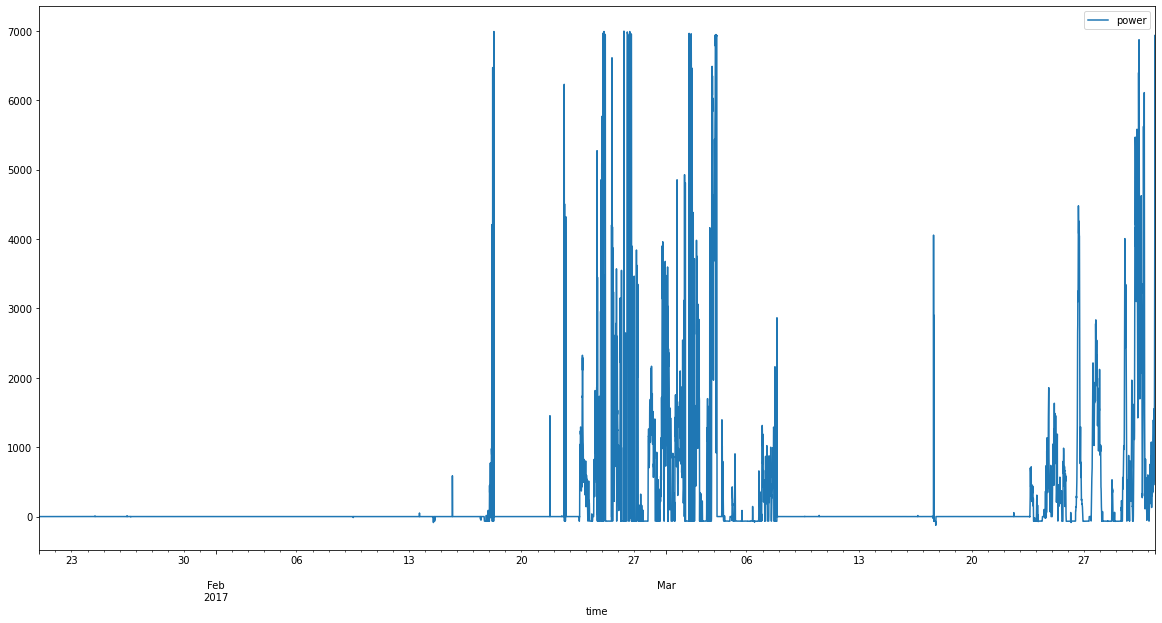

In [ ]:
df.iloc[:10000].plot(x="time", y="power", figsize=(20, 10))

#### Wind Rose

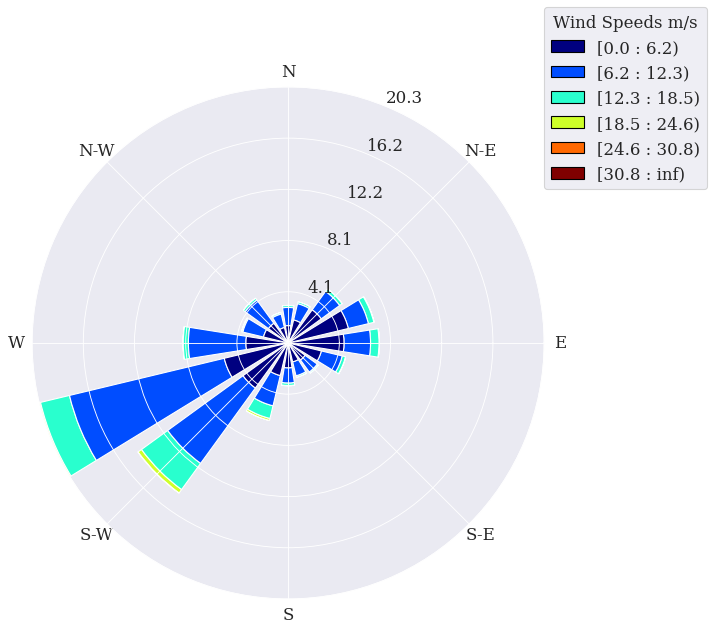

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(df.wind_direction, df.wind_speed_110m, normed=True, opening=0.8, edgecolor='white')
plt.legend(loc=(1,0.8), title="Wind Speeds m/s")
plt.show()

#### Turbine Wind Power Curve

In [4]:
sns.set_style("dark")
plt.rcParams['font.family'] = 'Serif'
plt.rcParams["font.size"] = 17

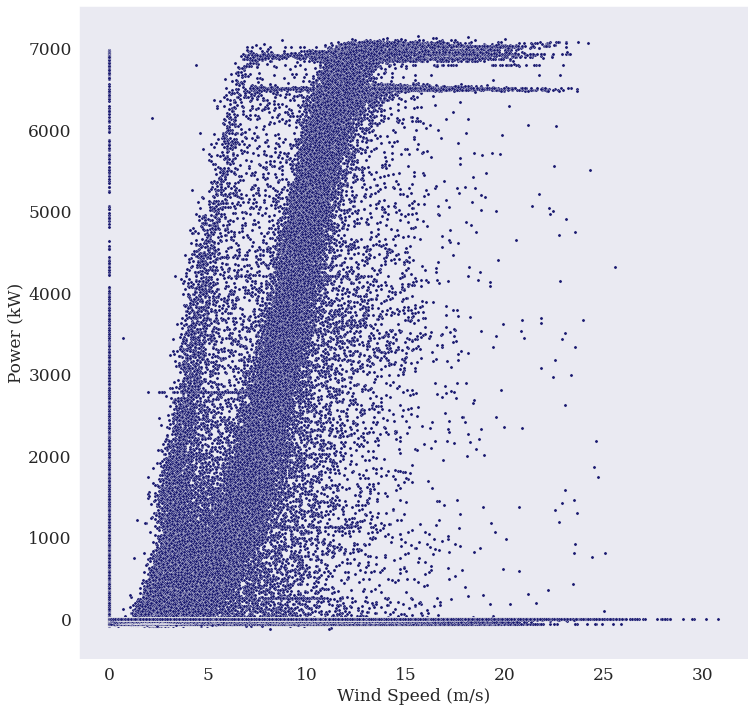

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(x="wind_speed_110m", y="power", data=df, s=10, c=["midnightblue"])
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.show()

#### Correlation Matrix

<AxesSubplot:>

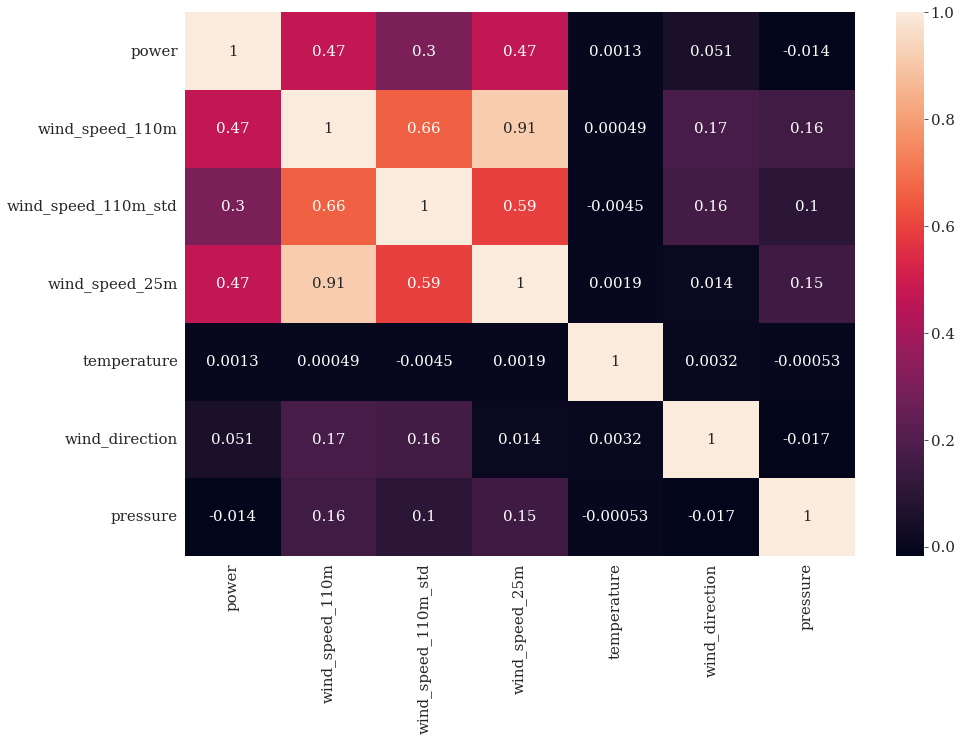

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

#### Weibull Distribution



In [ ]:
# Get only wind speeds greater than 0 and not nan
wind_speed = df[["wind_speed_110m"]][(df.wind_speed_110m.notna()) & (df.wind_speed_110m>0)]

In [ ]:
# Find scale and shape of Weibull distribution using weibull_min function from scipy
shape, loc, scale = weibull_min.fit(wind_speed.wind_speed_110m, floc=0)
print(f"{shape}, {scale}")

1.9240445646590165, 8.058790989212149


In [ ]:
def weibull_pdf(wind_speed, shape, scale):
    """
    Calculates the probability density function of the Weibull distribution based
    on wind shape and scale of the Weibull distribution.

    Parameters:
        wind_speed (float): The wind speed value.
        shape (float): The shape of the Weibull distribution.
        scale (float): The scale of the Weibull distribution

    Returns:
        pdf (float): The probability density function of the windspeed
    """
    pdf = (shape/scale) * (wind_speed/scale)**(shape-1) * np.exp(-(wind_speed/scale)**shape)
    return pdf

In [ ]:
wind_speed["pdf"] = wind_speed.wind_speed_110m.apply(weibull_pdf, shape=shape, scale=scale)

In [ ]:
wind_speed.sort_values("wind_speed_110m", inplace=True)

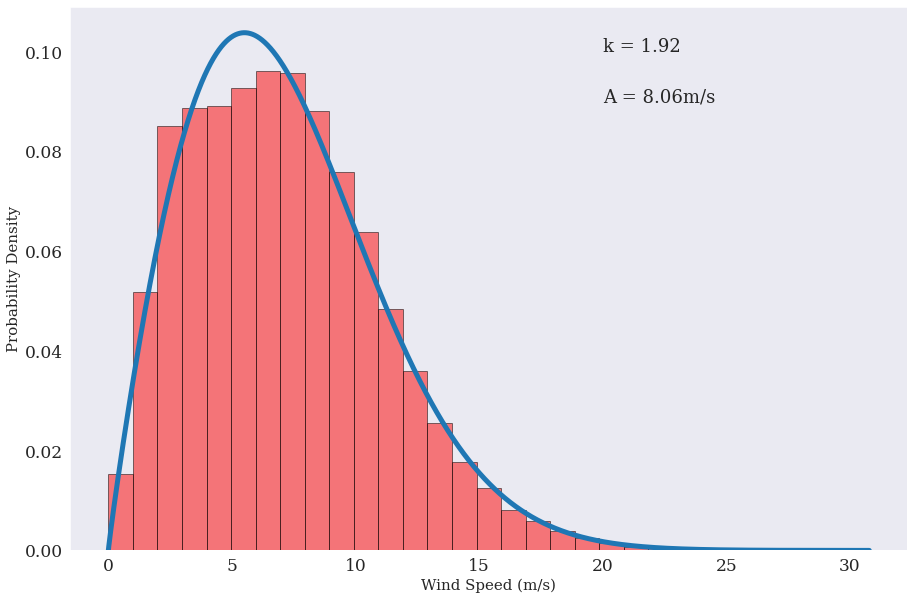

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(wind_speed.wind_speed_110m, wind_speed.pdf, linewidth=5)
plt.hist(wind_speed.wind_speed_110m, density=True, alpha=0.5, color="red", bins=31, ec='black')
plt.xlabel("Wind Speed (m/s)", fontsize=15)
plt.ylabel("Probability Density", fontsize=15)
plt.text(20, 0.10, f"k = {shape:.2f}", fontsize=18)
plt.text(20, 0.09, f"A = {scale:.2f}m/s", fontsize=18)
plt.show()

## Data Preprocessing

#### Missing Values
In the dataset their are missing values in order to impute Linear interpolation is used. Interpolation estimates the missing values by assuming a relationship within a range of data points. . Linear Interpolation is the simplest and fastest interpolation method. It simply draws a straight line through the two closest points, and the equation of a straight line can be used to determine the value of the point in-between.

In [ ]:
# Shows the percentage of each variable is missing.
(df.isna().sum() / len(df) * 100).apply(lambda x: f"{x:.2f} %")

time                   0.00 %
power                  1.44 %
wind_speed_110m        5.95 %
wind_speed_110m_std    5.96 %
wind_speed_25m         5.95 %
temperature            5.60 %
wind_direction         5.60 %
pressure               5.95 %
dtype: object

In [ ]:
columns = df.columns

In [ ]:
# Starting from 1 to exclude time
# Uses linear interpolation to impute missing values
df.loc[:, columns[1:]] = df.loc[:, columns[1:]].interpolate("linear")

In [ ]:
df.isna().sum()

time                   0
power                  0
wind_speed_110m        0
wind_speed_110m_std    0
wind_speed_25m         0
temperature            0
wind_direction         0
pressure               0
dtype: int64

#### Anomaly Detection

##### Temperature

From the descriptive stats of the temperature column we can confirm the presence of outliers.

In [ ]:
df.temperature.describe()

count    2.596110e+05
mean    -6.042120e+10
std      3.078583e+13
min     -1.568601e+16
25%      8.013474e+00
50%      1.145262e+01
75%      1.480113e+01
max      2.658698e+01
Name: temperature, dtype: float64

<AxesSubplot:xlabel='temperature', ylabel='Density'>

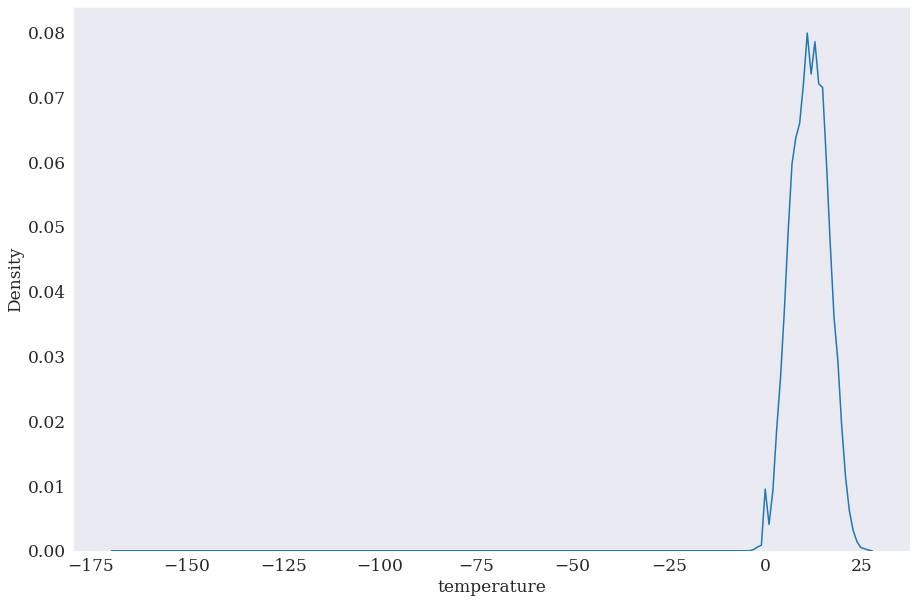

In [ ]:
# Distribution of Temperature values
plt.figure(figsize=(15, 10))
sns.kdeplot(df.temperature.drop(index=48045))

In [ ]:
# Clculte Z-scores of temperature values to find outliers
temperature = df.temperature.drop(index=48045)
z_score = (temperature - temperature.mean()) / temperature.std()

In [ ]:
# Find temperature values with z-score above 5
temperature[abs(z_score) > 5]

52906    -84.298991
52907    -23.707141
52925    -58.057727
52926   -127.104918
52927    -67.433793
53339   -146.310022
53340   -168.435657
Name: temperature, dtype: float64

In [ ]:
# Indices of outliers
index = [48045, 53340, 53339, 52926, 52906, 52927, 52925, 52907, 48045]

In [ ]:
# Replace with nan
df.loc[index, "temperature"] = np.nan

In [ ]:
# interpolate
df.temperature.interpolate("linear", inplace=True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
power,259611.0,1209.263875,2005.608217,-129.323129,-0.744898,0.000000,1632.679773,7149.039182
wind_speed_110m,259611.0,7.083816,3.892344,0.000000,4.061837,6.773796,9.548405,30.777336
wind_speed_110m_std,259611.0,0.684480,0.478947,0.000000,0.320554,0.572089,0.943456,10.022062
wind_speed_25m,259611.0,5.607733,3.185365,0.000000,3.276345,5.153546,7.351130,28.192528
temperature,259611.0,11.434711,4.666847,-3.772215,8.013886,11.452622,14.801130,26.586976
wind_direction,259611.0,191.078434,90.233582,0.000000,104.575853,223.473474,253.320042,359.986961
pressure,259611.0,1006.180115,108.538261,0.000000,1010.442215,1019.047348,1025.449240,1048.059903


In [ ]:
df.min()

time                   2017-01-21 00:00:00
power                          -129.323129
wind_speed_110m                        0.0
wind_speed_110m_std                    0.0
wind_speed_25m                         0.0
temperature                      -3.772215
wind_direction                         0.0
pressure                               0.0
dtype: object

#### Power Curve Filter

In [ ]:
df2 = df.copy()

In [ ]:
df2["outlier"] =  (~(df2.power>=0)) | ((df2.power==0) & (df2.wind_speed_110m>=3)) | ((df2.wind_speed_110m==0) & (df2.power!=0))

In [ ]:
df2["outlier"].value_counts()

True     136454
False    123157
Name: outlier, dtype: int64

In [ ]:
(df.index == outlier[~outlier].index).sum()

123157

In [ ]:
(len(df2) - 144775) / len(df2)

0.44233872986891926

In [ ]:
# Filter instances with negative power value
df = df[df.power>=0].copy()
print(len(df))

144775


In [ ]:
# Filter type 1 anomalies
df = df[~((df.power==0) & (df.wind_speed_110m>=3))]
print(len(df))

124914


In [ ]:
# filter out unidentified Anomaly
df = df[~((df.wind_speed_110m==0) & (df.power!=0))]

In [ ]:
len(df)

110683

#### Local Outlier Factor

In [ ]:
lof = LocalOutlierFactor()

In [ ]:
lof_outliers = lof.fit_predict(df[["wind_speed_110m", "power"]])

In [ ]:
df["outliers"] = lof_outliers

In [ ]:
df.loc[786].name

786

In [ ]:
pd.Series(lof_outliers).value_counts(normalize=True)

 1    0.898715
-1    0.101285
dtype: float64

In [ ]:
outlier.value_counts()

True     136454
False    123157
dtype: int64

In [ ]:
outlier.value_counts()

True     148928
False    110683
dtype: int64

In [ ]:
def func(x):
    if x["outliers"] == -1:
        outlier[x.name] = True

In [ ]:
df.apply(func, axis=1)

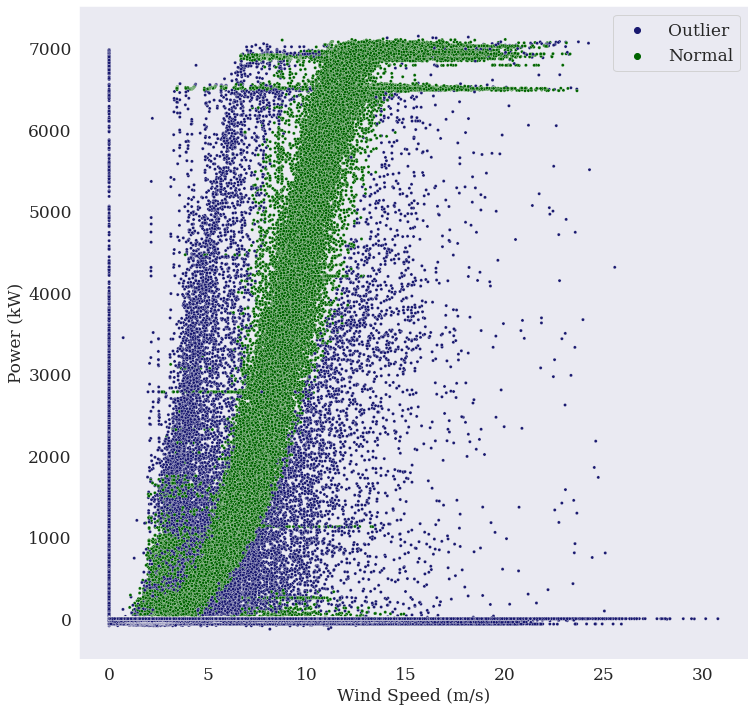

In [ ]:

plt.figure(figsize=(12,12))
sns.scatterplot(x="wind_speed_110m", y="power", data=df2, hue=outlier.apply(lambda x: "Outlier" if x else "Normal"), s=10, palette=["midnightblue", "darkgreen"])
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power (kW)")
plt.show()

#### Isolation Forest

In [ ]:
iso_forest = IsolationForest(n_estimators=20,max_features=2, verbose=1, contamination=0.11)

In [ ]:
if_outliers = iso_forest.fit_predict(df[["wind_speed_110m", "power"]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
pd.Series(if_outliers).value_counts(normalize=True)

 1    0.890148
-1    0.109852
dtype: float64

#### Elliptical Envelope

In [ ]:
ee = EllipticEnvelope(contamination=0.11)

In [ ]:
ee_outliers = ee.fit_predict(df[["wind_speed_110m", "power"]])

In [ ]:
pd.Series(ee_outliers).value_counts(normalize=True)

 1    0.889994
-1    0.110006
dtype: float64

#### Gaussian Mixture Models

In [ ]:
# The Bayesian information criterion is used to find best number of clusters to use
bic_list = []

for i in range(1, 30):
    gm = GaussianMixture(n_components=i)
    gm.fit(df[["wind_speed_110m", "power"]])
    bic_list.append(gm.bic(df[["wind_speed_110m", "power"]]))

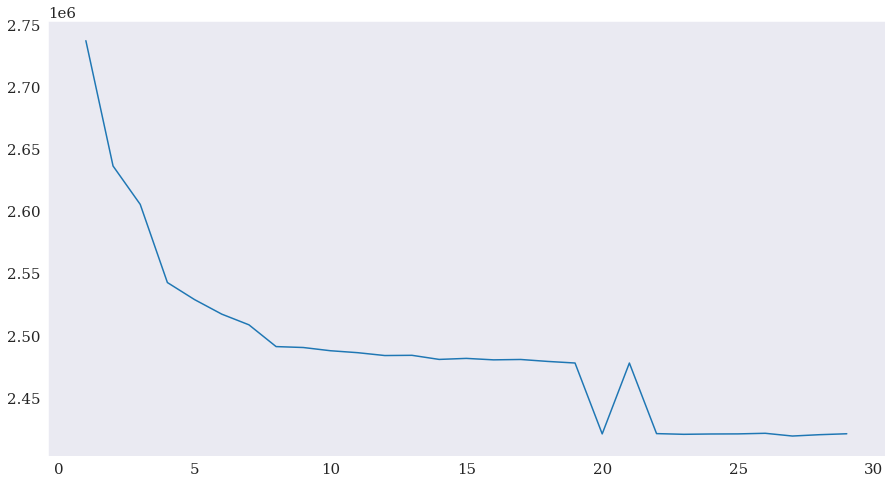

In [ ]:
# Use elbow plot to find good number of clusters for GMM
plt.figure(figsize=(15, 8))
plt.plot(range(1, 30), bic_list)
plt.show()

In [ ]:
gm = GaussianMixture(n_components=3)

In [ ]:
gm.fit(df[["wind_speed_110m", "power"]])

GaussianMixture(n_components=3)

In [ ]:
score_samples = gm.score_samples(df[["wind_speed_110m", "power"]])

<AxesSubplot:>

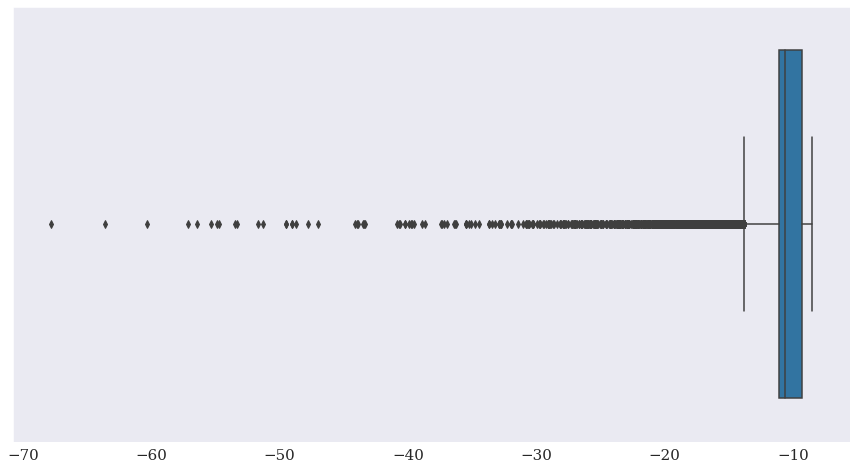

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=score_samples)

In [ ]:
gm_outliers = np.where(score_samples>-12.5, 1, -1)

Text(0, 0.5, 'Power (kW)')

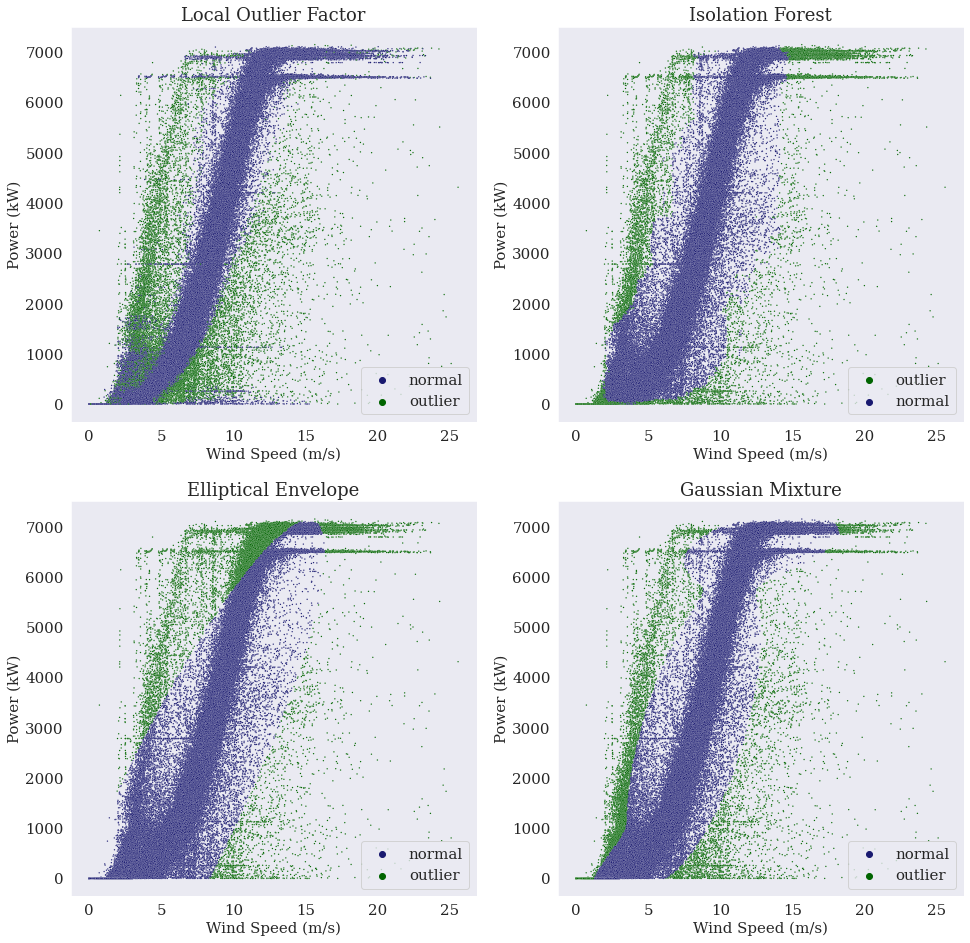

In [ ]:
fig = plt.figure(figsize=(16,16))
ax1, ax2, ax3, ax4 = fig.add_subplot(2,2,1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,3), fig.add_subplot(2,2,4)

sns.scatterplot(x="wind_speed_110m", y="power", data=df, hue=np.where(lof_outliers==1, "normal", "outlier"), s=2, palette=["midnightblue", "darkgreen"], ax=ax1)
ax1.set_title("Local Outlier Factor")
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Power (kW)")

sns.scatterplot(x="wind_speed_110m", y="power", data=df, hue=np.where(if_outliers==1, "normal", "outlier"), s=2, palette=["darkgreen", "midnightblue"], ax=ax2)
ax2.set_title("Isolation Forest")
ax2.set_xlabel("Wind Speed (m/s)")
ax2.set_ylabel("Power (kW)")

sns.scatterplot(x="wind_speed_110m", y="power", data=df, hue=np.where(ee_outliers==1, "normal", "outlier"), s=2, palette=["midnightblue", "darkgreen"], ax=ax3)
ax3.set_title("Elliptical Envelope")
ax3.set_xlabel("Wind Speed (m/s)")
ax3.set_ylabel("Power (kW)")

sns.scatterplot(x="wind_speed_110m", y="power", data=df, hue=np.where(gm_outliers==1, "normal", "outlier"), s=2, palette=["midnightblue", "darkgreen"], ax=ax4)
ax4.set_title("Gaussian Mixture")
ax4.set_xlabel("Wind Speed (m/s)")
ax4.set_ylabel("Power (kW)")

In [ ]:
# Since local outlier factor performed the best. It will be used.
df["outlier"] = lof_outliers

In [ ]:
df = df[df.outlier==1].copy()

In [ ]:
len(df)

110683

## Feature Engineering

#### U and V components of wind

In [ ]:
radians = df.wind_direction * np.pi / 180

In [ ]:
df['u_component'] = df.wind_speed_110m * np.cos(radians)
df['v_component'] = df.wind_speed_110m * np.sin(radians)

In [ ]:
df[["wind_speed_110m", "wind_direction", "u_component", "v_component"]].sample(frac=0.01)

,wind_speed_110m,wind_direction,u_component,v_component
76534,5.593364,213.982257,-4.638077,-3.126333
70115,3.156181,48.780617,2.079746,2.374054
130972,2.399977,76.734049,0.550726,2.335934
207895,10.594723,15.438650,10.212423,2.820383
81656,4.622964,250.602360,-1.535389,-4.360547
...,...,...,...,...
33851,2.805654,284.989763,0.725672,-2.710183
15106,7.122937,48.205386,4.747169,5.310425
96797,4.595188,55.153469,2.625600,3.771204
228086,7.914283,314.169685,5.514559,-5.676752


#### Turbulence Intensity
Wind turbulence is defined as the rapid fluctuations in wind speed and direction. This factor can have significant impact on the performance of the turbine. Turbulence Intensity is the std of wind speed divided by the mean wind speed.

In [ ]:
df["turbulence_intensity"] = df.wind_speed_110m_std / df.wind_speed_110m

In [ ]:
df[df.turbulence_intensity.isna()]

,time,power,wind_speed_110m,wind_speed_110m_std,wind_speed_25m,temperature,wind_direction,pressure,outlier,u_component,v_component,turbulence_intensity
11713,2017-04-12 08:10:00,0.0,0.0,0.0,0.0,10.508545,271.313086,0.0,1,0.0,-0.0,NaN
11714,2017-04-12 08:20:00,0.0,0.0,0.0,0.0,10.585139,271.610360,0.0,1,0.0,-0.0,NaN
11715,2017-04-12 08:30:00,0.0,0.0,0.0,0.0,10.661733,271.907634,0.0,1,0.0,-0.0,NaN
11716,2017-04-12 08:40:00,0.0,0.0,0.0,0.0,10.738327,272.204908,0.0,1,0.0,-0.0,NaN
11717,2017-04-12 08:50:00,0.0,0.0,0.0,0.0,10.814921,272.502182,0.0,1,0.0,-0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
56226,2018-02-15 11:00:00,0.0,0.0,0.0,0.0,3.949138,185.161828,0.0,1,-0.0,-0.0,NaN
64853,2018-04-16 08:50:00,0.0,0.0,0.0,0.0,10.380499,179.787615,0.0,1,-0.0,0.0,NaN
66874,2018-04-30 09:40:00,0.0,0.0,0.0,0.0,7.863655,221.337667,0.0,1,-0.0,-0.0,NaN
68481,2018-05-11 13:30:00,0.0,0.0,0.0,0.0,12.211756,105.615706,0.0,1,-0.0,0.0,NaN


In [ ]:
df[df.wind_speed_110m_std==df.wind_speed_110m].equals(df[df.turbulence_intensity.isna()])

True

In [ ]:
# Fill nan values of turbulence intensity with zeros since they are cases where both wind speed mean
# and std are 0 meaning there are no fluctuations in wind.
df.turbulence_intensity.fillna(0, inplace=True)

#### Wind Shear



In [ ]:
def wind_shear_exp(x):
    """
    Calculates the Wind Shear of the dataset

    Parameters:
        x (pandas.DataFrame): A single row of the dataset
    """
    v1, v2 = x["wind_speed_25m"], x["wind_speed_110m"]
    h1, h2 = 25, 110

    if v1==v2:   # Checks if v1 and v2 have the same value
        return 0 # If both have the same value then  wind shear is zero
    elif 0 in (v1, v2): # If either wind speeds are zero it is going to return a ZeroDivisionError or Undefined value
        return np.nan
    return np.log(v2/v1) / np.log(h2/h1)

In [ ]:
df["wind_shear"] = df.apply(wind_shear_exp, axis=1)

In [ ]:
df[df.wind_shear.isna()]

,time,power,wind_speed_110m,wind_speed_110m_std,wind_speed_25m,temperature,wind_direction,pressure,outlier,u_component,v_component,turbulence_intensity,wind_shear
43758,2017-11-20 21:00:00,0.0,0.000000,0.000000,2.179825,8.217984,331.265686,1014.825721,1,0.000000,-0.000000,0.000000,NaN
56748,2018-02-19 02:00:00,0.0,2.176103,0.192429,0.000000,6.396593,179.433304,1019.757053,1,-2.175996,0.021523,0.088428,NaN


In [ ]:
df.wind_shear.interpolate("linear", inplace=True)

#### Air Density



In [ ]:
def air_density(x):
    """
    Calculates the air density of the dataset

    Parameters:
        x (pandas.DataFrame): A single row of the dataset

    Returns:
        rho (float): The air density of the row
    """
    rho = x["pressure"] / (287.04 * (x["temperature"] + 273.15))
    return rho

In [ ]:
df["air_density"] = df.apply(air_density, axis=1)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Save cleaned file to drive
# df.to_csv("/content/gdrive/MyDrive/ai-and-ds/thesis/turbine.csv")

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/ai-and-ds/thesis/turbine.csv", index_col=0)

#### Feature Selection

In [6]:
features = ['wind_speed_110m', 'temperature', 'pressure', 
            'u_component', 'v_component', 'turbulence_intensity', 
            'wind_shear', 'air_density']

In [7]:
X = df[features]
y = df["power"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

#### Normalisation

In [9]:
scaler = MinMaxScaler(copy=True)

In [10]:
scaler.fit(X_train)

MinMaxScaler()

In [11]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Building

In [ ]:
rf = RandomForestRegressor(n_estimators=200, verbose=1)

In [ ]:
%%time
rf.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 3min 18s, sys: 469 ms, total: 3min 19s
Wall time: 3min 18s


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished


RandomForestRegressor(n_estimators=200, verbose=1)

In [ ]:
dump(rf, '/content/gdrive/MyDrive/ai-and-ds/thesis/rf.joblib')

['/content/gdrive/MyDrive/ai-and-ds/thesis/rf.joblib']

In [ ]:
# rf = load('/content/gdrive/MyDrive/ai-and-ds/thesis/rf.joblib') 

In [ ]:
y_pred = rf.predict(X_train_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.0s finished


In [ ]:
rf_train_mae = mean_absolute_error(y_train, y_pred)
rf_train_rmse = sqrt(mean_squared_error(y_train, y_pred))
rf_train_r2 = r2_score(y_train, y_pred)

In [ ]:
rf_train_mae, rf_train_rmse, rf_train_r2

(84.22466910446894, 160.97055855398153, 0.9950198877804942)

In [ ]:
rf_y_pred = rf.predict(X_test_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.8s finished


In [ ]:
rf_test_mae = mean_absolute_error(y_test, rf_y_pred)
rf_test_rmse = sqrt(mean_squared_error(y_test, rf_y_pred))
rf_test_r2 = r2_score(y_test, rf_y_pred)

In [ ]:
rf_test_mae, rf_test_rmse, rf_test_r2

(227.7018698650535, 430.65060537165476, 0.9644508315670143)

In [ ]:
feature_names_importance = zip(features, rf.feature_importances_ * 100)
feature_names_importance = dict(sorted(feature_names_importance, key=lambda x: x[1], reverse=True))

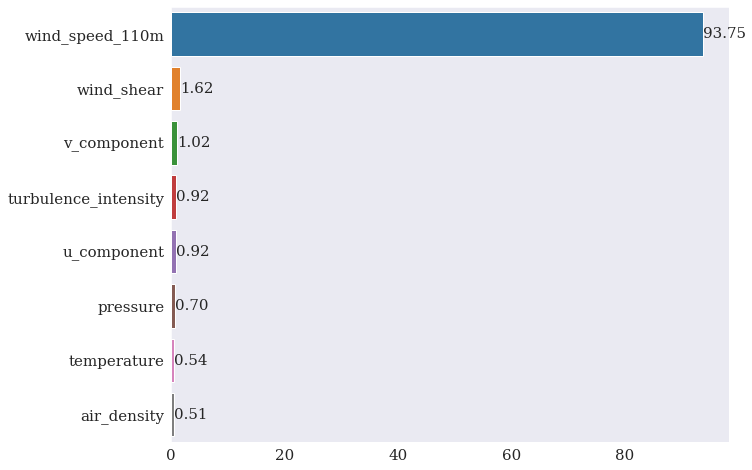

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=list(feature_names_importance.values()), y=list(feature_names_importance.keys()), capsize=0.2, ax=ax)
ax.bar_label( ax.containers[-1], fmt='%.2f', label_type='edge')
plt.show()

#### XGBOOST

In [12]:
xgb_parameters = {"objective": "reg:squarederror", "seed": 42}
num_boost_round = 2000

train_dmatrix = xgboost.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgboost.DMatrix(X_test_scaled, label=y_test)
watch_list = [(train_dmatrix, "train"), (test_dmatrix, "test")]

In [ ]:
xgb = None

In [ ]:
%%time
xgb = xgboost.train(xgb_parameters, train_dmatrix, num_boost_round=num_boost_round, xgb_model=xgb, evals=watch_list, early_stopping_rounds=15)

[0]	train-rmse:2435.25	test-rmse:2439.68
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 15 rounds.
[1]	train-rmse:1747.69	test-rmse:1752.31
[2]	train-rmse:1280.08	test-rmse:1284.38
[3]	train-rmse:967.877	test-rmse:973.089
[4]	train-rmse:767.571	test-rmse:773.506
[5]	train-rmse:644.364	test-rmse:652.143
[6]	train-rmse:571.92	test-rmse:580.738
[7]	train-rmse:526.411	test-rmse:537.17
[8]	train-rmse:502.735	test-rmse:514.518
[9]	train-rmse:486.996	test-rmse:498.915
[10]	train-rmse:472.897	test-rmse:486.105
[11]	train-rmse:467.42	test-rmse:481.306
[12]	train-rmse:461.186	test-rmse:476.625
[13]	train-rmse:454.878	test-rmse:471.403
[14]	train-rmse:451.712	test-rmse:468.39
[15]	train-rmse:448.229	test-rmse:466.491
[16]	train-rmse:446.549	test-rmse:465.885
[17]	train-rmse:443.135	test-rmse:463.723
[18]	train-rmse:441.849	test-rmse:462.76
[19]	train-rmse:439.495	test-rmse:460.659
[20]	train-rmse:435.38	test-rmse

In [ ]:
# xgb.save_model("/content/gdrive/MyDrive/ai-and-ds/thesis/xgb.model")

In [13]:
xgb = xgboost.Booster({"nthread": 4})
xgb.load_model("/content/gdrive/MyDrive/ai-and-ds/thesis/xgb.model")

In [14]:
y_pred = xgb.predict(train_dmatrix, ntree_limit=175)

In [15]:
xgb_train_mae = mean_absolute_error(y_train, y_pred)
xgb_train_rmse = sqrt(mean_squared_error(y_train, y_pred))
xgb_train_r2 = r2_score(y_train, y_pred)

In [16]:
xgb_train_mae, xgb_train_rmse, xgb_train_r2

(197.0057703659628, 326.2080818187932, 0.9795480058411538)

In [17]:
xgb_y_pred = xgb.predict(test_dmatrix, ntree_limit=175)

In [18]:
xgb_test_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_test_rmse = sqrt(mean_squared_error(y_test, xgb_y_pred))
xgb_test_r2 = r2_score(y_test, xgb_y_pred)

In [19]:
xgb_test_mae, xgb_test_rmse, xgb_test_r2

(237.70961226580064, 424.9390688865669, 0.9653875257260096)

In [ ]:
xgb_test_mae, xgb_test_rmse, xgb_test_r2

(237.70961226580064, 424.9390688865669, 0.9653875257260096)

In [ ]:
gain = xgb.get_score(importance_type="gain")

In [ ]:
feature_importance = dict(sorted(gain.items(), key=lambda x: x[0]))

In [ ]:
feature_names_importance = zip(features, feature_importance.values())
feature_names_importance = dict(sorted(feature_names_importance, key=lambda x: x[1], reverse=True))

In [ ]:
total_gain = sum(feature_names_importance.values())

In [ ]:
for key, value in feature_names_importance.items():
    feature_names_importance[key] = (value/total_gain) * 100

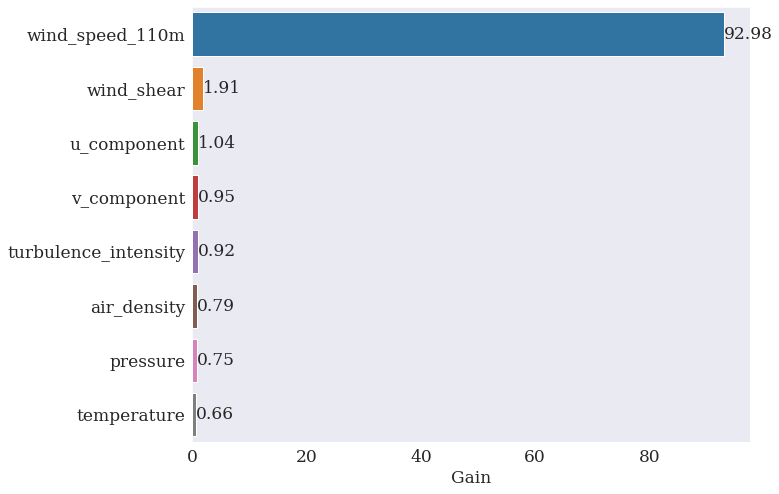

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=list(feature_names_importance.values()), y=list(feature_names_importance.keys()), capsize=0.2, ax=ax)
ax.bar_label( ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_xlabel("Gain")
plt.show()

In [ ]:
ax.set_xlabel("Gain")

Text(0.5, 3.200000000000003, 'Gain')

#### Neural Network

In [ ]:
nn1 = models.Sequential()

In [ ]:
nn1.add(layers.Dense(units=32, activation="relu", input_shape=(8,)))
nn1.add(layers.Dense(units=32, activation="relu"))
nn1.add(layers.Dense(units=32, activation="relu"))
nn1.add(layers.Dense(1))

In [ ]:
nn1.compile(loss="mse", optimizer='adam', metrics=['mae'])

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=15)
checkpoint = callbacks.ModelCheckpoint("/content/gdrive/MyDrive/ai-and-ds/thesis/nn1", save_best_only=True)

In [ ]:
%%time
epochs = 1000
history = nn1.fit(X_train_scaled, y_train, batch_size=128, epochs=epochs, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/1000
692/692 [==============================] - 6s 7ms/step - loss: 6659286.0000 - mae: 2023.5986 - val_loss: 3673028.7500 - val_mae: 1648.2013
Epoch 2/1000
692/692 [==============================] - 5s 8ms/step - loss: 1717799.5000 - mae: 1028.9489 - val_loss: 814869.3750 - val_mae: 668.1249
Epoch 3/1000
692/692 [==============================] - 6s 9ms/step - loss: 666016.4375 - mae: 574.2208 - val_loss: 587812.1875 - val_mae: 521.5437
Epoch 4/1000
692/692 [==============================] - 3s 4ms/step - loss: 547318.2500 - mae: 496.9576 - val_loss: 504141.1562 - val_mae: 471.6035
Epoch 5/1000
692/692 [==============================] - 2s 4ms/step - loss: 467936.5625 - mae: 440.8144 - val_loss: 436249.8125 - val_mae: 407.9229
Epoch 6/1000
692/692 [==============================] - 3s 4ms/step - loss: 400410.7188 - mae: 377.6852 - val_loss: 386946.0312 - val_mae: 357.8936
Epoch 7/1000
692/692 [==============================] - 3s 4ms/step - loss: 358935.8438 - mae: 333.8389 - 

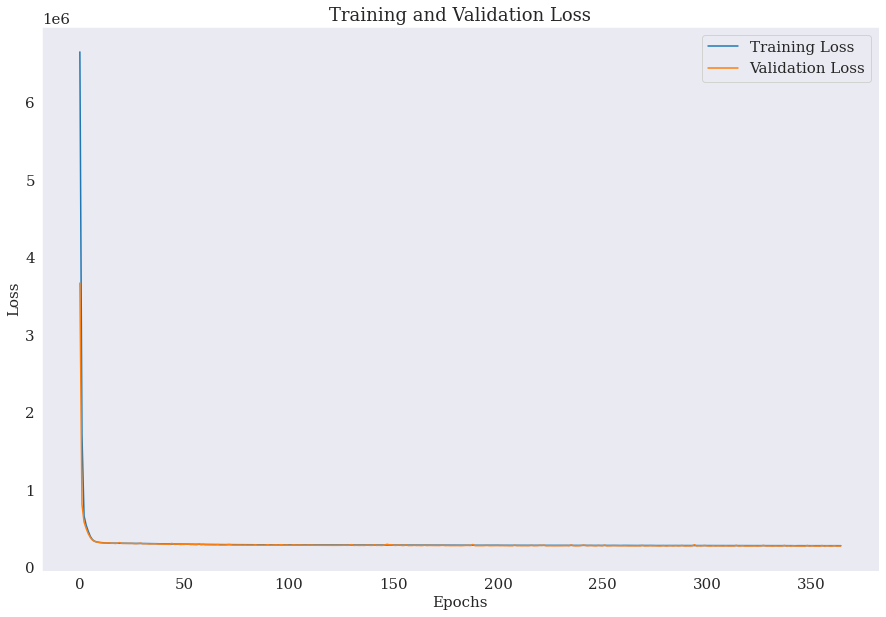

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.epoch))

plt.figure(figsize=(15, 10))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
model = models.load_model("/content/gdrive/MyDrive/ai-and-ds/thesis/nn1")

In [ ]:
y_pred = model.predict(X_train_scaled)

In [ ]:
nn1_train_mae = mean_absolute_error(y_train, y_pred)
nn1_train_rmse = sqrt(mean_squared_error(y_train, y_pred))
nn1_train_r2 = r2_score(y_train, y_pred)

In [ ]:
nn1_train_mae, nn1_train_rmse, nn1_train_r2

(268.8690565746517, 527.9542029902491, 0.9464278926744977)

In [ ]:
nn1_y_pred = model.predict(X_test_scaled)

In [ ]:
nn1_test_mae = mean_absolute_error(y_test, nn1_y_pred)
nn1_test_rmse = sqrt(mean_squared_error(y_test, nn1_y_pred))
nn1_test_r2 = r2_score(y_test, nn1_y_pred)

In [ ]:
nn1_test_mae, nn1_test_rmse, nn1_test_r2

(269.17037057083166, 524.8192329911756, 0.947204269115939)

#### Neural Network with 8 hidden layers

In [ ]:
nn2 = models.Sequential()

In [ ]:
nn2.add(layers.Dense(units=64, activation="relu", input_shape=(8,)))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(units=64, activation="relu"))
nn2.add(layers.Dense(1))

In [ ]:
nn2.compile(loss="mse", optimizer='adam', metrics=['mae'])

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=15)
checkpoint = callbacks.ModelCheckpoint("/content/gdrive/MyDrive/ai-and-ds/thesis/nn2", save_best_only=True)

In [ ]:
%%time
epochs = 1000
history = nn2.fit(X_train_scaled, y_train, batch_size=128, epochs=epochs, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/1000
692/692 [==============================] - 8s 11ms/step - loss: 2062346.3750 - mae: 852.2622 - val_loss: 345939.6875 - val_mae: 323.8112
Epoch 2/1000
692/692 [==============================] - 9s 12ms/step - loss: 339980.9375 - mae: 321.1096 - val_loss: 321902.2812 - val_mae: 297.5844
Epoch 3/1000
692/692 [==============================] - 3s 5ms/step - loss: 323728.2812 - mae: 306.8257 - val_loss: 328056.6875 - val_mae: 321.2738
Epoch 4/1000
692/692 [==============================] - 6s 9ms/step - loss: 317465.2812 - mae: 301.5990 - val_loss: 300977.3125 - val_mae: 289.3694
Epoch 5/1000
692/692 [==============================] - 4s 6ms/step - loss: 310666.9688 - mae: 296.4548 - val_loss: 295935.4375 - val_mae: 282.3967
Epoch 6/1000
692/692 [==============================] - 3s 4ms/step - loss: 307116.7812 - mae: 293.8100 - val_loss: 312897.4688 - val_mae: 308.4904
Epoch 7/1000
692/692 [==============================] - 5s 7ms/step - loss: 306373.2812 - mae: 294.9501 - val

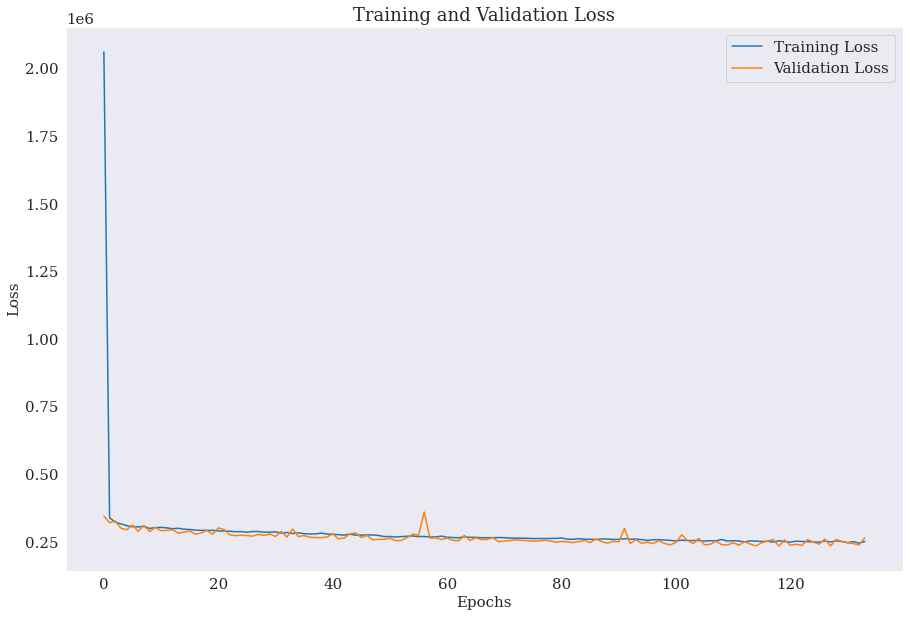

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(15, 10))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
model = models.load_model("/content/gdrive/MyDrive/ai-and-ds/thesis/nn2")

In [ ]:
y_pred = model.predict(X_train_scaled)

In [ ]:
nn2_train_mae = mean_absolute_error(y_train, y_pred)
nn2_train_rmse = sqrt(mean_squared_error(y_train, y_pred))
nn2_train_r2 = r2_score(y_train, y_pred)

In [ ]:
nn2_train_mae, nn2_train_rmse, nn2_train_r2

(253.99026889430726, 489.0553368487345, 0.9540312989352439)

In [ ]:
nn2_y_pred = model.predict(X_test_scaled)

In [ ]:
nn2_test_mae = mean_absolute_error(y_test, nn2_y_pred)
nn2_test_rmse = sqrt(mean_squared_error(y_test, nn2_y_pred))
nn2_test_r2 = r2_score(y_test, nn2_y_pred)

In [ ]:
nn2_test_mae, nn2_test_rmse, nn2_test_r2

(254.92212580559732, 485.10555572872926, 0.9548921820511126)

### Actual vs Predicted Plot

In [20]:
linspace = np.linspace(0, 8000, 100)

In [21]:
sns.set_style("dark")
plt.rcParams['font.family'] = 'Serif'
plt.rcParams["font.size"] = 15

(0.0, 7500.0)

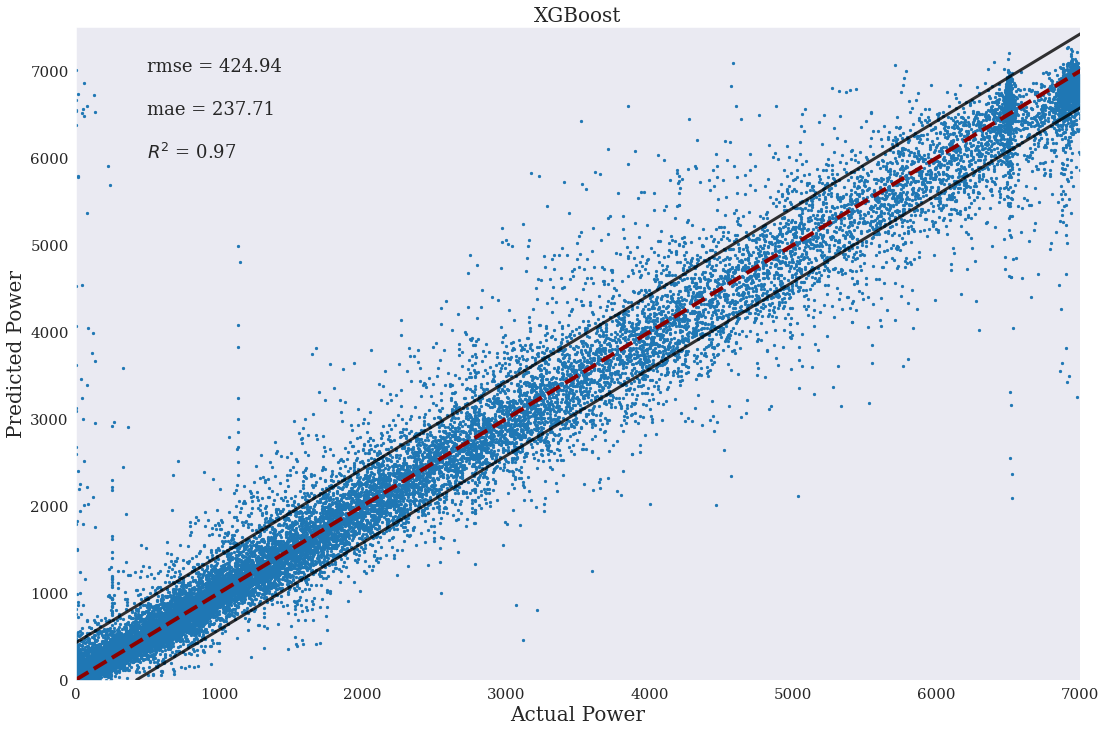

In [22]:
plt.figure(figsize=(18,12))
plt.scatter(x=y_test, y=xgb_y_pred, s=5)
plt.plot(linspace, linspace, '--', linewidth=4, c="darkred")
plt.plot(linspace + xgb_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
plt.plot(linspace - xgb_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
plt.title("XGBoost", fontsize=20)
plt.ylabel("Predicted Power", fontsize=20)
plt.xlabel("Actual Power", fontsize=20)
plt.text(500, 7000, f"rmse = {xgb_test_rmse:.2f}", fontsize=18)
plt.text(500, 6500, f"mae = {xgb_test_mae:.2f}", fontsize=18)
plt.text(500, 6000, f"$R^2$ = {xgb_test_r2:.2f}", fontsize=18)

plt.xlim(0, 7000)
plt.ylim(0, 7500)

(0.0, 7500.0)

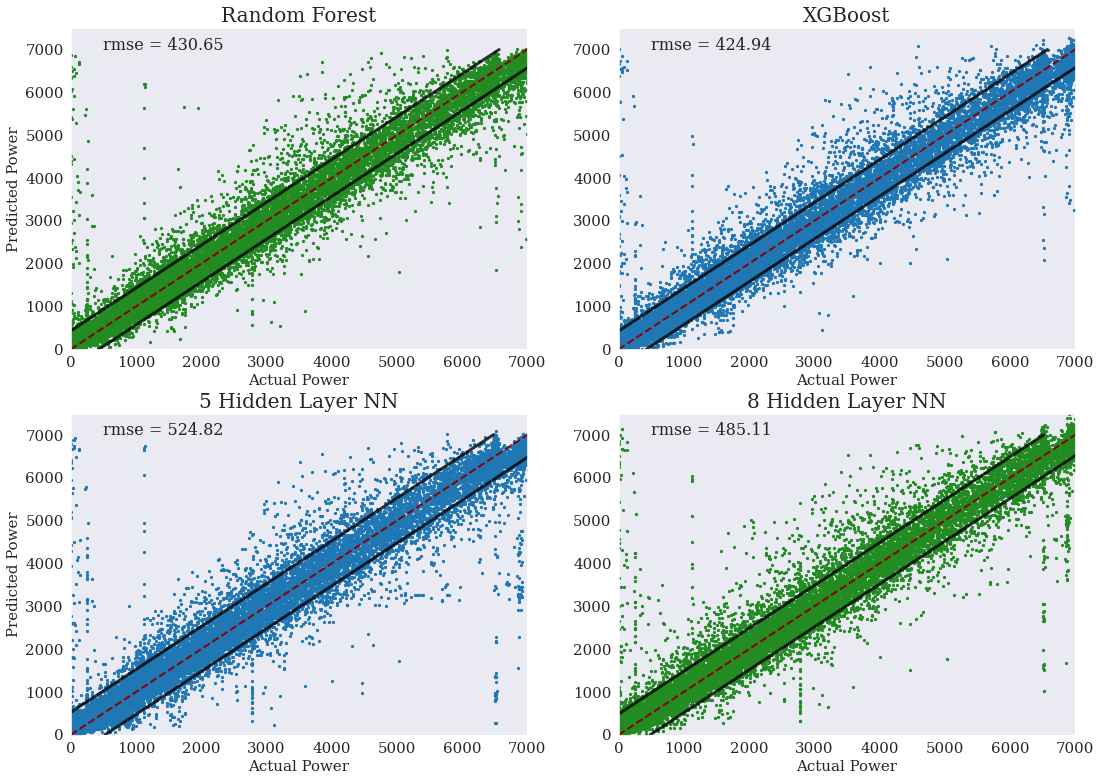

In [ ]:
fig = plt.figure(figsize=(18,13))
ax1, ax2, ax3, ax4 = fig.add_subplot(2,2,1), fig.add_subplot(2,2,2), fig.add_subplot(2,2,3), fig.add_subplot(2,2,4)

ax1.scatter(x=y_test, y=rf_y_pred, s=5, c="forestgreen")
ax1.plot(linspace, linspace, '--', linewidth=2, c="darkred")

ax1.plot(linspace + rf_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax1.plot(linspace - rf_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)

ax1.set_title("Random Forest", fontsize=20)
ax1.set_xlabel("Actual Power")
ax1.set_ylabel("Predicted Power")
ax1.text(500, 7000, f"rmse = {rf_test_rmse:.2f}", fontsize=16)
ax1.set_xlim(0, 7000)
ax1.set_ylim(0, 7500)

ax2.scatter(x=y_test, y=xgb_y_pred, s=5)
ax2.plot(linspace, linspace, '--', linewidth=2, c="darkred")
ax2.plot(linspace + xgb_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax2.plot(linspace - xgb_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax2.set_title("XGBoost", fontsize=20)
ax2.set_xlabel("Actual Power")
ax2.text(500, 7000, f"rmse = {xgb_test_rmse:.2f}", fontsize=16)
ax2.set_xlim(0, 7000)
ax2.set_ylim(0, 7500)

ax3.scatter(x=y_test, y=nn1_y_pred, s=5)
ax3.plot(linspace, linspace, '--', linewidth=2, c="darkred")
ax3.plot(linspace + nn1_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax3.plot(linspace - nn1_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax3.set_title("5 Hidden Layer NN", fontsize=20)
ax3.set_xlabel("Actual Power")
ax3.set_ylabel("Predicted Power")
ax3.text(500, 7000, f"rmse = {nn1_test_rmse:.2f}", fontsize=16)
ax3.set_xlim(0, 7000)
ax3.set_ylim(0, 7500)

ax4.scatter(x=y_test, y=nn2_y_pred, s=5, c="forestgreen")
ax4.plot(linspace, linspace, '--', linewidth=2, c="darkred")
ax4.plot(linspace + nn2_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax4.plot(linspace - nn2_test_rmse, linspace, '-', linewidth=3, c="black", alpha=0.8)
ax4.set_title("8 Hidden Layer NN", fontsize=20)
ax4.set_xlabel("Actual Power")
ax4.text(500, 7000, f"rmse = {nn2_test_rmse:.2f}", fontsize=16)
ax4.set_xlim(0, 7000)
ax4.set_ylim(0, 7500)